<font size='200' style='font-family:Georgia' color='midnightblue'>APS 3</font> 


## <font style='font-family:Georgia' color='teal'> Estudo de uma treliça plana</font> 


####  <font style='font-family:Georgia' color='darkturquoise'> André Tavernaro || Antonio Fuzyi || Gabriela Mitu || Gabriella Cukier</font> 

### Importando bibliotecas e valores

In [43]:
from funcoesTermosol import *
import numpy as np
import math
import tqdm

### Representação da estrutura

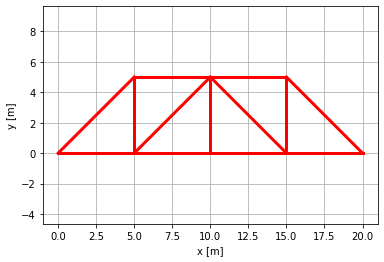

In [44]:
entrada = "trelica.xlsx"

[nn,N,nm,Inc,nc,F,nr,R] = importa(entrada)

plota(N, Inc)
# geraSaida()

### Informações sobre a treliça

* nn: número de nós
* N: Matriz dos nós
* nm: número de membros
* Inc: Matriz de incidência. Colunas:
    1. Nó 1
    2. Nó 2
    3. E
    4. A
* nc: número de cargas
* F: forças (Vetor carregamento)
* nr: número de restrições
* R: Restrições (Vetor com os graus de liberdade)

In [45]:
# Comprimento 
L = 5
#numero de nodes
n = 8

In [46]:
nodes = np.zeros((2, n))
print(nodes)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


### Gerando a matriz de conectividade transposta

In [47]:
C = []
for i in range(nm):
        C_i = nn*[0]

        no_1 = int(Inc[i, 0])
        no_2 = int(Inc[i, 1])

        C_i[no_1-1] = -1
        C_i[no_2-1] = 1
        C.append(C_i) 

C_t = np.array(C).T
C_t

array([[-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0, -1, -1,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  1,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  0, -1, -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1]])

### Matriz dos membros (M)

In [48]:
M = np.matmul(N, C_t)
print(M)

[[ 5.  5.  0.  5.  5.  5.  0.  5.  5.  5.  0.  5.  5.]
 [ 0.  5.  5.  5.  0.  0. -5. -5.  0.  0.  5.  0. -5.]]


### Obtendo Se, Ke e Kg

In [49]:
len_linhas_M = len(M)
len_linhas_C = len(C_t)
Kg = np.zeros((16, 16))
for i in range(0, nm):
    E = Inc[i,2]
    A = Inc[i,3]
    const = E*A/L
    
    M_aux = M[:,i]
    M_aux.shape = [len_linhas_M, 1]
    M_aux2 = np.transpose(M_aux)
    Se = (const * np.matmul(M_aux, M_aux2)) / (np.linalg.norm(M[:,i])**2)

    C_aux = C_t[:,i]
    C_aux.shape = [len_linhas_C, 1]
    C_aux2 = np.transpose(C_aux)
    multi_C_aux = np.matmul(C_aux, C_aux2)
    Ke = np.kron(multi_C_aux, Se)
    Kg += Ke
# print(Se)
print(Kg)

[[ 4.45320760e+09  1.48440253e+09 -2.96880507e+09  0.00000000e+00
  -1.48440253e+09 -1.48440253e+09  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.48440253e+09  1.48440253e+09  0.00000000e+00  0.00000000e+00
  -1.48440253e+09 -1.48440253e+09  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.96880507e+09  0.00000000e+00  7.42201268e+09  1.48440253e+09
   0.00000000e+00  0.00000000e+00 -1.48440253e+09 -1.48440253e+09
  -2.96880507e+09  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.48440253e+09  4.45320760e+09
   0.00000000e+00 -2.96880507e+09 -1.48440253e+09 -1.48440253e+09
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00

### Deslocamento nodal

In [50]:
def compara_solucoes(array1, array2):
    return max(abs((s2 - s1)/s2) for s1,s2 in zip(array1, array2))

In [51]:
def solucao_gauss(k, F, ite, tol):
    
    matriz_x = np.zeros((F.shape[0], 1)) #cria uma matriz nx1
    matriz_compare = matriz_x.copy() #salva os valores da iteração anterior
    
    for iteracao in range(ite):
        for indice in range(matriz_x.shape[0]):
            b = F[indice]
            ax = sum(a*x for a,x in zip(k[indice, :], matriz_x[:,0])) - k[indice, indice]*matriz_x[indice,0]            
            matriz_x[indice] = (b - ax)/k[indice, indice]
        
        erro = compara_solucoes(matriz_compare[:,0], matriz_x[:,0])
        
        
        
        if erro < tol and iteracao > 1:
            print("Convergiu na {0}º iteracao".format(iteracao))
            break
        else:
            print("                                  ", end="\r")
            print("Erro: {0}".format(erro), end="\r")
            matriz_compare = matriz_x.copy() #atualiza valores 
        
    return matriz_x

def solucao_jacobi(k, F, ite, tol):
    
    matriz_x = np.zeros((F.shape[0], 1)) #cria uma matriz nx1
    matriz_x_auxiliar = np.zeros((F.shape[0], 1))
    
    for iteracao in range(ite):
        for indice in range(matriz_x.shape[0]):
            b = F[indice]
            ax = sum(a*x for a,x in zip(k[indice, :], matriz_x[:,0])) - k[indice, indice]*matriz_x[indice,0]            
            matriz_x_auxiliar[indice] = (b - ax)/k[indice, indice]
            
        matriz_x = matriz_x_auxiliar
        
    return matriz_x

In [52]:
u = solucao_jacobi(Kg, F, 100, 1e-3)
u2 = solucao_gauss(Kg, F, 100, 1e-3)
print("-"*8, "JACOBI", "-"*8)
print(u)
print("-"*8, "GAUSS", "-"*8)
print(u2)

-------- JACOBI --------
[[ 1.56485946e-05]
 [ 9.13255637e-04]
 [ 1.09328926e-05]
 [ 9.25828940e-04]
 [ 3.74896406e-06]
 [ 9.34586672e-04]
 [ 3.74896406e-06]
 [ 9.43791616e-04]
 [ 8.27816937e-07]
 [ 9.43791616e-04]
 [-9.27725877e-06]
 [ 9.29418049e-04]
 [ 3.74896406e-06]
 [ 9.38175782e-04]
 [-1.39929608e-05]
 [ 9.20433857e-04]]
-------- GAUSS --------
[[ 1.45924144e-05]
 [ 9.14996907e-04]
 [ 9.87671242e-06]
 [ 9.28664450e-04]
 [ 1.59854305e-06]
 [ 9.37422183e-04]
 [ 1.59854305e-06]
 [ 9.47721367e-04]
 [-2.28363293e-07]
 [ 9.47721367e-04]
 [-1.03334390e-05]
 [ 9.34442042e-04]
 [ 1.59854305e-06]
 [ 9.43199774e-04]
 [-1.50491410e-05]
 [ 9.26552090e-04]]
<ipython-input-50-147fa590b8c3>:2: RuntimeWarning: invalid value encountered in double_scalars
  return max(abs((s2 - s1)/s2) for s1,s2 in zip(array1, array2))


In [53]:
c = math.cos(45)
s = math.sin(45)

# for i in range(nm):


In [54]:
# geraSaida("saida", , u, , , Kg)

### Reações de apoio

In [55]:
P = np.matmul(Kg,u)
P

array([[-4.24806785e-08],
       [-1.40000000e+04],
       [-1.40280463e-08],
       [-4.20000000e+04],
       [ 1.40000000e+04],
       [ 4.00000000e+04],
       [ 1.40000000e+04],
       [ 1.80000000e+04],
       [ 1.67601684e-08],
       [ 0.00000000e+00],
       [-1.40000000e+04],
       [-2.80000000e+04],
       [-1.60071068e-10],
       [ 2.60000000e+04],
       [-1.40000000e+04],
       [-1.60071068e-10]])

In [56]:
P_r = np.zeros((nr,1))
for i in range(nr):  
    index = int(R[i])
    P_r[i] = P[index]    
P_r

array([[-4.24806785e-08],
       [-1.40000000e+04],
       [-4.20000000e+04],
       [-2.80000000e+04],
       [-1.60071068e-10],
       [-1.40000000e+04]])

In [57]:
def tensao_e_deformacao(n_elemento, n_de_membros, matriz_u, m_incidencia, m_nos, A):
    """
    função responsável por calcular a tensão e deformação para cada membro
    recebe: número do membro desejado [inteiro], número total de membros [inteiro], matriz u calculada (completa), matriz de incidencia, matriz de nós.
    retorna: tensão [inteiro] e deformação [inteiro] calculadas para o membro desejado
    """
    
   
    no_1 = int(m_incidencia[n_elemento-1, 0])
    no_2 = int(m_incidencia[n_elemento-1, 1])     
    
    matriz_aux = np.array((
            matriz_u[(no_1-1)*2], 
            matriz_u[(no_1-1)*2 +1], 
            matriz_u[(no_2-1)*2], 
            matriz_u[(no_2-1)*2 +1]))
    
    
    E =  m_incidencia[n_elemento-1, 2]  
    
    no_1 = int(m_incidencia[n_elemento-1, 0])
    no_2 = int(m_incidencia[n_elemento-1, 1])
    
    # Pegar a coordenada do no_1
    x_no1 = m_nos[0, no_1-1]
    y_no1 = m_nos[1, no_1-1]
    
    # Pegar a coordenada do no_2
    x_no2 = m_nos[0, no_2-1]
    y_no2 = m_nos[1, no_2-1]
    
    l = math.sqrt((x_no2-x_no1)**2+(y_no2-y_no1)**2)
    
    sen = (y_no2-y_no1)/l #calcula seno do elemento
    cos = (x_no2-x_no1)/l #calcula coss do elemento
    
    c = np.array(([-cos, -sen, cos, sen]))
    
    tensao = (E/l) * np.dot(c, matriz_aux)
    forca = (E/l) * np.dot(c, matriz_aux)*A
    deformacao = (1/l) * np.dot(c, matriz_aux)
    
    return tensao[0], deformacao[0], forca[0]

In [72]:
forcas = []
deformacoes = [] 
tensoes = []
for i in range(nm):
    lista1 = []
    lista2 = [] 
    lista3 = []

    tensao, deformacao, forca = tensao_e_deformacao(i+1, nm, u, Inc, N, Inc[0,2])
    lista1.append(tensao)
    tensoes.append(lista1)
    lista2.append(deformacao)
    deformacoes.append(lista2)
    lista3.append(forca)
    forcas.append(lista3)
    print("Membro {0}: tensao: {1} | deformacao: {2} | força: {3}".format(i+1, tensao, deformacao, forca))


Membro 1: tensao: -198059.48391147173 | deformacao: -9.431403995784368e-07 | força: -4.1592491621409064e+16
Membro 2: tensao: 198059.48391207552 | deformacao: 9.43140399581312e-07 | força: 4.159249162153586e+16
Membro 3: tensao: 367824.75583694567 | deformacao: 1.7515464563664079e-06 | força: 7.72431987257586e+16
Membro 4: tensao: 226353.69589948727 | deformacao: 1.0778747423785108e-06 | força: 4.753427613889233e+16
Membro 5: tensao: -7.115076756936123e-10 | deformacao: -3.3881317890172014e-21 | força: -149.41661189565858
Membro 6: tensao: -424413.17981076014 | deformacao: -2.0210151419560007e-06 | força: -8.912676776025963e+16
Membro 7: tensao: 0.0 | deformacao: 0.0 | força: 0.0
Membro 8: tensao: 28294.211987263643 | deformacao: 1.3473434279649355e-07 | força: 5941784517325365.0
Membro 9: tensao: -424413.1798109972 | deformacao: -2.02101514195713e-06 | força: -8.91267677603094e+16
Membro 10: tensao: 3.5575383784680614e-11 | deformacao: 1.6940658945086008e-22 | força: 7.470830594782929

In [70]:
# matriz = np.zeros((1, nm))
# for i in range(nm):
#     lista = []
#     matriz[0][i] = forcas[i]
#     lista.append(matriz[0][i])

In [73]:
geraSaida("saida", P_r, u, deformacoes, forcas, tensoes)

### Deformação específica

A deformação específica pode ser
calculada a partir dos
deslocamentos nodais do elemento
de barra.

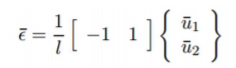

In [60]:
u

array([[ 1.56485946e-05],
       [ 9.13255637e-04],
       [ 1.09328926e-05],
       [ 9.25828940e-04],
       [ 3.74896406e-06],
       [ 9.34586672e-04],
       [ 3.74896406e-06],
       [ 9.43791616e-04],
       [ 8.27816937e-07],
       [ 9.43791616e-04],
       [-9.27725877e-06],
       [ 9.29418049e-04],
       [ 3.74896406e-06],
       [ 9.38175782e-04],
       [-1.39929608e-05],
       [ 9.20433857e-04]])

### Tensões internas

Por sua vez, a tensão no elemento de barra é 𝜎 = 𝐸 ∙ 𝜖 

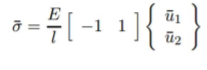

In [61]:
# acho q se tiver a deformação, dá pra fazer cada um vezes E

### Tensões internas

In [62]:
# Daria pra fazer tensão vezes área pra cada um?

In [63]:
# FALTA
# Deformações
# Forças internas
# Tensões internas